The theory for this notebook is developed in `ZonotopesNonlinearReach`.

In [1]:
# load packages
using Plots
using LazySets, MathematicalSystems, Reachability
using LazySets.Approximations
using Reachability: center
using Reachability.ReachSets: Φ₁
using IntervalArithmetic, ValidatedNumerics
using LazySets: Interval, translate
using TaylorSeries
using TaylorSeries: gradient, jacobian, hessian, derivative
const ∂ = derivative

┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1184


derivative (generic function with 10 methods)

In [3]:
@time begin
# number of Taylor terms considered in the linearization
taylor_terms = 4

# define the working variables and fix the max order in the Taylor series expansion
x = set_variables("x", numvars=2, order=taylor_terms)

# define the ODE
f = Vector{TaylorN{Float64}}(undef, 2)
f[1] = x[2]
f[2] = x[2] * (1-x[1]^2) - x[1]

# define the initial-value problem
𝑋₀ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
𝑆 = BlackBoxContinuousSystem(f, 2)
𝑃 = InitialValueProblem(𝑆, 𝑋₀)

# take the gradient of the vector field symbolically
#∇f = [gradient(f[i]) for i in 1:2]

# take the Jacobian matrix of the vector field symbolically
#Jf = [∂(f[1], (1, 0)) ∂(f[1], (0, 1));
#      ∂(f[2], (1, 0)) ∂(f[2], (0, 1))]

# algorithm-specific options
O = Options(:δ => 0.02, :δcont => 0.02/10, :max_order=>2, :θ=>fill(0.05, 2))

# unwrap options
δ = O[:δ]
θ = O[:θ]

# collection of flowpipes
Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
end

  0.000791 seconds (594 allocations: 33.047 KiB)


0-element Array{ReachSet{Hyperrectangle{Float64},Float64},1}

In [38]:
@time begin
x̃, 𝑆lin = linearize(𝑃, δ)
end;

  0.000118 seconds (416 allocations: 23.078 KiB)


In [39]:
# use zonotope-based continuous reach
@time begin
𝑃lin = InitialValueProblem(𝑆lin, 𝑋₀i)
Rlin_zono = solve(𝑃lin, Options(:T=>O[:δ]), op=GLGM06(:δ=>O[:δcont], :max_order=>O[:max_order]))
end;

  0.070020 seconds (4.26 k allocations: 506.313 KiB)


In [40]:
# use decomposition-based continuous reach
@time begin
𝑃lin = InitialValueProblem(𝑆lin, 𝑋₀i)
Rlin_box = solve(𝑃lin, Options(:T=>O[:δ]), op=BFFPSV18(:δ=>O[:δcont]))
end;

  0.029150 seconds (2.21 k allocations: 331.031 KiB)


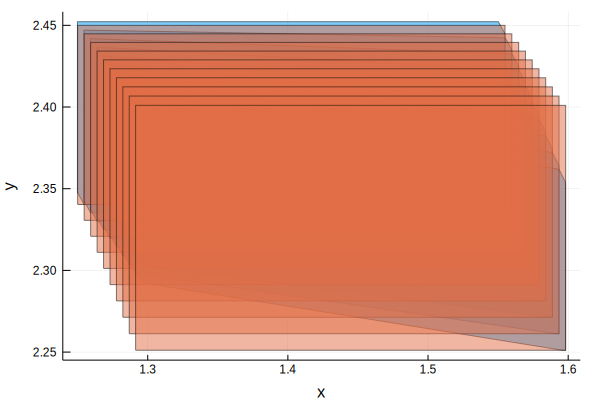

In [41]:
plot(Rlin_zono, alpha=.5)
plot!(Rlin_box, alpha=.5, xlab="x", ylab="y")

In [43]:
# decide which continuoust post to use
Rlin = Rlin_zono

@time begin
R̄err, L̄ = admissible_error(Ax̃, δ, θ; n=2)
L = lagrange_remainder(f, Rlin, R̄err, x̃; n=2)
end

  0.000623 seconds (2.33 k allocations: 129.203 KiB)


Hyperrectangle{Float64}([0.0, 0.0], [0.0, 0.138466])

In [20]:
if L ⊆ L̄
    # split
    error("split is not implemented")
else
   _add_chunk!(Rsets, Rlin, R̄err)
end
t0 = Rsets[end].t_end

0.020000000000000004

In [25]:
#plot([Rsets[i].X for i in 1:length(Rsets)])

### Algorithm

In [45]:
# use BFFPSV18
Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()

#=
x̃, 𝑆lin = linearize(𝑃, δ)
R̄err, L̄ = admissible_error(Ax̃, δ, θ)
L = lagrange_remainder(f, Rlin, R̄err, x̃)

if L ⊆ L̄
    # split
    error("split is not implemented")
else
   _add_chunk!(Rsets, Rlin, R̄err)
end
t0 = Rsets[end].t_end
=#

0-element Array{ReachSet{Hyperrectangle{Float64},Float64},1}

### Appendix: auxiliary functions

BlackBoxContinuousSystem

In [36]:
function linearize(𝑃::IVP{<:BBCS}, δ)

    # nonlinear ODE
    f = 𝑃.s.f
    
    # initial set of current chunk
    𝑋₀i = 𝑃.x0

    # linearization point for current chunk
    c = center(𝑋₀i)
    x̃ = c + δ/2 * f(c)

    # evaluate Jacobian at the linearization point
    Ax̃ = jacobian(f, x̃) #  map(x -> evaluate(x, x̃), Jf)
    bx̃ = f(x̃) - Ax̃ * x̃

    # instantiate linearized system; it doesn't have state constraints
    𝑆lin = ConstrainedAffineContinuousSystem(Ax̃, bx̃, Universe(2));
    return x̃, 𝑆lin
end

linearize (generic function with 2 methods)

In [ ]:
function _add_chunk!(Rsets, Rlin, R̄err)
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = Rlin.Xk[i].X ⊕ R̄err
        Ri = overapproximate(Ri, Hyperrectangle)
        Ri = ReachSet(Ri, Rlin.Xk[i].t_start, Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

In [16]:
function admissible_error(Ax̃, δ, θ; n=2)
    @assert n == 2
    Φ₁_Aδ = Φ₁(Ax̃, δ)
    R̄err = Hyperrectangle(zeros(2), θ*δ)
    l̄ = abs.(inv(Φ₁_Aδ)) * θ * δ
    L̄ = Hyperrectangle(zeros(2), l̄)
    return R̄err, L̄
end

admissible_error (generic function with 1 method)

In [13]:
function lagrange_remainder(f, Rlin, R̄err, x̃; n=2)
    @assert n == 2
    
    Hf₁ = [∂(f[1], (2, 0)) ∂(f[1], (1, 1));
           ∂(f[1], (1, 1)) ∂(f[1], (0, 2))]
    Hf₂ = [∂(f[2], (2, 0)) ∂(f[2], (1, 1));
           ∂(f[2], (1, 1)) ∂(f[2], (0, 2))]

    R̂lin = ConvexHullArray([Ri.X for Ri in Rlin.Xk]) ⊕ R̄err
    R̂lin_rect = overapproximate(R̂lin, Hyperrectangle)

    ξ = CH(Singleton(x̃), R̂lin_rect)
    ξ_rect = overapproximate(ξ, Hyperrectangle)
    ξ_box = convert(IntervalBox, ξ_rect)

    Hf₁_box = map(Hf_ij -> evaluate(Hf_ij, ξ_box), Hf₁)
    Hf₂_box = map(Hf_ij -> evaluate(Hf_ij, ξ_box), Hf₂)

    R̂lin_zono = convert(Zonotope, R̂lin_rect)

    γ = abs.(R̂lin_zono.center - x̃) + sum(abs.(R̂lin_zono.generators), dims=2)
    
    G = [sup.(abs.(Hf₁_box)), sup.(abs.(Hf₂_box))];
    li_zono = [(1/2 * transpose(γ) * G[i] * γ)[1, 1] for i in 1:n]
    L = Hyperrectangle(zeros(n), li_zono)
    return L
end

lagrange_remainder (generic function with 1 method)